<a href="https://colab.research.google.com/github/Connor1208/git-basics-activity/blob/main/MTH3230_Assignment3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torch.nn as nn
import yfinance as yf
import pandas as pd
from torch import Tensor
from typing import List
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Daily open/high/low/close/volume for Apple (AAPL), 1980–present.
# Forecasting task: Predict next-day closing price or return.
aapl = yf.Ticker("AAPL")
hist = aapl.history(period="max")
# hist = aapl.history(period="1mo")
display(hist.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-10-15 00:00:00-04:00,249.490005,251.820007,247.470001,249.339996,33893600,0.0,0.0
2025-10-16 00:00:00-04:00,248.250000,249.039993,245.130005,247.449997,39777000,0.0,0.0
2025-10-17 00:00:00-04:00,248.020004,253.380005,247.270004,252.289993,49147000,0.0,0.0
2025-10-20 00:00:00-04:00,255.889999,264.380005,255.630005,262.239990,90483000,0.0,0.0
2025-10-21 00:00:00-04:00,261.880005,265.290009,261.829987,262.769989,46659000,0.0,0.0


In [ ]:
# The input data that we want to use to predict tmr's closing value
# TODO: This should be edited to be a window of past features
X = pd.DataFrame(index=hist.index)
X["Close"] = hist["Close"]
X["Volume"] = hist["Volume"]
X["rolling_mean_7"] = hist["Close"].rolling(7).mean()
X["rolling_mean_30"] = hist["Close"].rolling(30).mean()
X["rolling_std_7"] = hist["Close"].rolling(7).std()
X["rolling_std_30"] = hist["Close"].rolling(30).std()
X["pct_change"] = hist["Close"].pct_change()
X = X.dropna()

# The output that we wish to predict is tmr's closing value from historical data
y = X["Close"].shift(-1) # returns copy

# Drop the last row as we can't predict tmr's closing value
y = y.drop(y.index[-1])
X = X.drop(X.index[-1])

# Convert to arrays
y = y.values
X = X.values

print("Size of y: ", y.shape)
print("Size of X: ", X.shape)


Size of y:  (11276,)
Size of X:  (11276, 7)


In [ ]:
# Ref: https://medium.com/@mn05052002/building-a-simple-mlp-from-scratch-using-pytorch-7d50ca66512b
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for training performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Epoch 1/30, Train Loss: 0.121152
Epoch 2/30, Train Loss: 0.002231
Epoch 3/30, Train Loss: 0.001969
Epoch 4/30, Train Loss: 0.001593
Epoch 5/30, Train Loss: 0.001568
Epoch 6/30, Train Loss: 0.001511
Epoch 7/30, Train Loss: 0.001310
Epoch 8/30, Train Loss: 0.001314
Epoch 9/30, Train Loss: 0.001369
Epoch 10/30, Train Loss: 0.001375
Epoch 11/30, Train Loss: 0.001114
Epoch 12/30, Train Loss: 0.001194
Epoch 13/30, Train Loss: 0.001404
Epoch 14/30, Train Loss: 0.001188
Epoch 15/30, Train Loss: 0.001134
Epoch 16/30, Train Loss: 0.001203
Epoch 17/30, Train Loss: 0.001237
Epoch 18/30, Train Loss: 0.001125
Epoch 19/30, Train Loss: 0.001181
Epoch 20/30, Train Loss: 0.001098
Epoch 21/30, Train Loss: 0.001020
Epoch 22/30, Train Loss: 0.001164
Epoch 23/30, Train Loss: 0.001073
Epoch 24/30, Train Loss: 0.001490
Epoch 25/30, Train Loss: 0.001135
Epoch 26/30, Train Loss: 0.001045
Epoch 27/30, Train Loss: 0.001380
Epoch 28/30, Train Loss: 0.000972
Epoch 29/30, Train Loss: 0.001245
Epoch 30/30, Train Loss

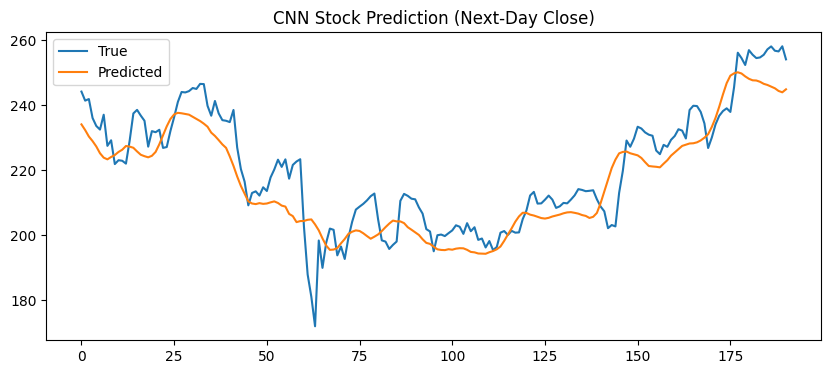

In [45]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# --- Prepare windowed data ---
def create_sequences(X, y, window=10):
    """Convert to overlapping sequences of length `window`."""
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

window = 10
X_seq, y_seq = create_sequences(X, y, window)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

# --- Normalise ---
scaler_X = StandardScaler()
n_samples, seq_len, n_features = X_train.shape
X_train = scaler_X.fit_transform(X_train.reshape(-1, n_features)).reshape(n_samples, seq_len, n_features)
X_test = scaler_X.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape[0], seq_len, n_features)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

# --- Convert to tensors ---
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# --- Define 1D CNN model ---
class CNN1D(nn.Module):
    def __init__(self, in_features):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_features, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)   # -> (batch, features, seq_len)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # -> (batch, 64)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out

model = CNN1D(in_features=X_train.shape[2])

# --- Training setup ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

# --- Training loop ---
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.6f}")

# --- Evaluation ---
model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy()
    preds = scaler_y.inverse_transform(preds)
    y_true = scaler_y.inverse_transform(y_test)

mse = np.mean((preds - y_true)**2)
print(f"Test MSE: {mse:.4f}")

# --- Plot predictions ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_true[-200:-9], label='True')
plt.plot(preds[-200+9:], label='Predicted')
plt.legend()
plt.title("CNN Stock Prediction (Next-Day Close)")
plt.show()


In [ ]:
# --- Visualise CNN architecture with torchviz ---
!pip install torchviz torchsummary --quiet

from torchviz import make_dot
from torchsummary import summary

# Create a dummy input (same shape as your actual input)
example_input = torch.randn(1, X_train.shape[1], X_train.shape[2])   # (batch=1, seq_len=10, features=7)

# Forward pass
output = model(example_input)

# Visualise computation graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('cnn_graph')   # saves cnn_graph.png in the working directory

# Print detailed layer summary
print("Model summary:\n")
summary(model, input_size=(X_train.shape[1], X_train.shape[2]))


Model summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 32, 8]             704
              ReLU-2                [-1, 32, 8]               0
            Conv1d-3                [-1, 64, 6]           6,208
              ReLU-4                [-1, 64, 6]               0
 AdaptiveAvgPool1d-5                [-1, 64, 1]               0
            Linear-6                   [-1, 32]           2,080
              ReLU-7                   [-1, 32]               0
            Linear-8                    [-1, 1]              33
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


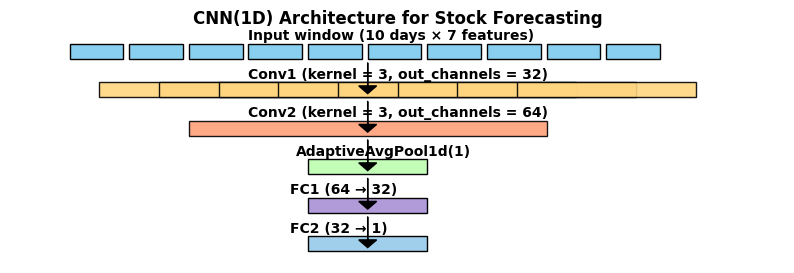

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_cnn_timeline(window=10, kernel_size=3):
    fig, ax = plt.subplots(figsize=(10, 3))

    # --- Input window (10 days) ---
    for i in range(window):
        ax.add_patch(patches.Rectangle((i, 2.3), 0.9, 0.4, color="#89CFF0", ec="k"))
    ax.text(window/2 - 2, 2.8, f"Input window ({window} days × 7 features)", fontsize=10, fontweight="bold")

    # --- Conv1 layer kernels (3-day filters) ---
    for start in range(window - kernel_size + 1):
        ax.add_patch(patches.Rectangle((start + 0.5, 1.3), kernel_size, 0.4, color="#FFD580", ec="k", alpha=0.9))
    ax.text(window/2 - 2, 1.8, f"Conv1 (kernel = {kernel_size}, out_channels = 32)", fontsize=10, fontweight="bold")

    # --- Conv2 layer ---
    ax.add_patch(patches.Rectangle((2, 0.3), 6, 0.4, color="#FFA07A", ec="k", alpha=0.9))
    ax.text(window/2 - 2, 0.8, "Conv2 (kernel = 3, out_channels = 64)", fontsize=10, fontweight="bold")

    # --- Pooling and Dense layers ---
    ax.add_patch(patches.Rectangle((4, -0.7), 2, 0.4, color="#C3FDB8", ec="k"))
    ax.text(3.8, -0.2, "AdaptiveAvgPool1d(1)", fontsize=10, fontweight="bold")

    ax.add_patch(patches.Rectangle((4, -1.7), 2, 0.4, color="#B19CD9", ec="k"))
    ax.text(3.7, -1.2, "FC1 (64 → 32)", fontsize=10, fontweight="bold")

    ax.add_patch(patches.Rectangle((4, -2.7), 2, 0.4, color="#A0CFEC", ec="k"))
    ax.text(3.7, -2.2, "FC2 (32 → 1)", fontsize=10, fontweight="bold")

    # --- Arrows ---
    for y1, y2 in zip([2.3, 1.3, 0.3, -0.7, -1.7], [1.3, 0.3, -0.7, -1.7, -2.7]):
        ax.arrow(window/2, y1 - 0.1, 0, y2 - y1 + 0.4, head_width=0.3, head_length=0.2, fc='k', ec='k')

    ax.set_xlim(-1, window + 2)
    ax.set_ylim(-3, 3)
    ax.axis("off")
    ax.set_title("CNN(1D) Architecture for Stock Forecasting", fontsize=12, fontweight="bold")
    plt.show()

visualize_cnn_timeline(window=10, kernel_size=3)


In [149]:
import torch
import torch.nn as nn
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
from typing import List
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



TICKER = "AAPL"
PERIOD = "max"
WINDOW = 30 # lookback days for features
BATCH = 64
EPOCHS = 30
LEARNING_RATE = 1e-3
HIDDEN = [128, 64] # MLP hidden sizes
P_DROPOUT = 0.1
ACTIVATION_FN = nn.ReLU
CRITERION = nn.MSELoss
OPTIMIZER = torch.optim.Adam
PATIENCE = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Create a DataFrame to display model params
params = pd.DataFrame({
    'Parameter': ['Input Window Size', 'Input Data Range', 'Hidden Layers',
                'Activation Function', 'Optimizer', 'Dropout P', 'Eval Metric',
                'Batch Size', 'Learning Rate', 'Patience'],
    'Value': [WINDOW, PERIOD, HIDDEN, ACTIVATION_FN, OPTIMIZER, P_DROPOUT, CRITERION,
            BATCH, LEARNING_RATE, PATIENCE]
})

display(params)



# Daily open/high/low/close/volume for Apple (AAPL), 1980–present.
# Forecasting task: Predict next-day closing price or return.
tick = yf.Ticker(TICKER)
hist = tick.history(period=PERIOD)
display(hist.tail())



# The input data that we want to use to predict tmr's closing value
X = pd.DataFrame(index=hist.index)
X["Close"] = hist["Close"]
X["Volume"] = hist["Volume"]
X["rolling_mean_3"] = hist["Close"].rolling(3).mean()
X["rolling_mean_14"] = hist["Close"].rolling(14).mean()
X["rolling_std_3"] = hist["Close"].rolling(3).std()
X["rolling_std_14"] = hist["Close"].rolling(14).std()
X["pct_change"] = hist["Close"].pct_change()
X = X.dropna()

# The output that we wish to predict is tmr's closing value from historical data
# The output at day i will be the closing value at day (i + 1)
y = X["Close"].shift(-1)

# Drop the last row as we don't have an output for the present day
y = y.drop(y.index[-1])
X = X.drop(X.index[-1])

# Number of features
NUM_FEATURES = X.shape[1]

print("Size of y: ", y.shape)
print("Size of X: ", X.shape)



def build_windows(X, y, window_size):
    Xw, yw = [], []

    for i in range(window_size - 1 , len(X)):

        # input: days (i - window_size + 1), (i - window_size + 2), ..., i
        Xw.append(X.values[i - window_size + 1:i + 1, :])

        # output: next-day close => close at day (i + 1) => y[i]
        yw.append(y.values[i])

    Xw = np.stack(Xw).reshape(-1, window_size * NUM_FEATURES) # (N, W*F)
    yw = np.array(yw).reshape(-1, 1) # (N, 1)

    return Xw, yw

Xw, yw = build_windows(X, y, WINDOW)




# Ref: https://medium.com/@mn05052002/building-a-simple-mlp-from-scratch-using-pytorch-7d50ca66512b
X_train, X_tmp, y_train, y_tmp = train_test_split(Xw, yw, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

# Standardize the data for training performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)





train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
val_ds = TensorDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, drop_last=False)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, drop_last=False)

,Parameter,Value
0,Input Window Size,30
1,Input Data Range,max
2,Hidden Layers,"[128, 64]"
3,Activation Function,<class 'torch.nn.modules.activation.ReLU'>
4,Optimizer,<class 'torch.optim.adam.Adam'>
5,Dropout P,0.1
6,Eval Metric,<class 'torch.nn.modules.loss.MSELoss'>
7,Batch Size,64
8,Learning Rate,0.001
9,Patience,5


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-10-16 00:00:00-04:00,248.250000,249.039993,245.130005,247.449997,39777000,0.0,0.0
2025-10-17 00:00:00-04:00,248.020004,253.380005,247.270004,252.289993,49147000,0.0,0.0
2025-10-20 00:00:00-04:00,255.889999,264.380005,255.630005,262.239990,90483000,0.0,0.0
2025-10-21 00:00:00-04:00,261.880005,265.290009,261.829987,262.769989,46695900,0.0,0.0
2025-10-22 00:00:00-04:00,262.649994,262.850006,255.429993,258.450012,44954300,0.0,0.0


Size of y:  (11293,)
Size of X:  (11293, 7)


In [150]:
# ======== Run the same 1D-CNN for window sizes 5, 20, 100 (30 epochs each) ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_window(window_size: int):
    # --- Rebuild windows for this size ---
    Xw, yw = build_windows(X, y, window_size)

    # Splits (chronological)
    X_train, X_tmp, y_train, y_tmp = train_test_split(Xw, yw, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

    # Scale (fit on train only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_val   = torch.tensor(X_val,   dtype=torch.float32)
    y_val   = torch.tensor(y_val,   dtype=torch.float32).reshape(-1, 1)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_test  = torch.tensor(y_test,  dtype=torch.float32).reshape(-1, 1)

    # Loaders
    train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True,  drop_last=False)
    val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=64, shuffle=False, drop_last=False)
    test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=64, shuffle=False, drop_last=False)

    # Model (Conv1d(F->32)->ReLU->Conv1d(32->64)->ReLU->Flatten->Dropout(0.1)->Linear->1)
    class CNNRegressor(nn.Module):
        def __init__(self, in_ch=NUM_FEATURES, seq_len=window_size):
            super().__init__()
            self.conv1 = nn.Conv1d(in_ch, 32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
            self.act   = nn.ReLU()
            self.drop  = nn.Dropout(0.1)
            self.fc    = nn.Linear(64 * seq_len, 1)
        def forward(self, x: Tensor) -> Tensor:
            x = self.act(self.conv1(x))
            x = self.act(self.conv2(x))
            x = torch.flatten(x, 1)
            x = self.drop(x)
            return self.fc(x)

    model = CNNRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def eval_mse(dataloader):
        model.eval()
        tot, n = 0.0, 0
        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(device), yb.to(device)
                xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)
                pred = model(xb)
                tot += criterion(pred, yb).item() * xb.size(0)
                n += xb.size(0)
        return tot / max(n, 1)

    # Train exactly 30 epochs
    for epoch in range(1, 30 + 1):
        model.train()
        tr_tot, tr_n = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            tr_tot += loss.item() * xb.size(0)
            tr_n   += xb.size(0)

        train_mse = tr_tot / tr_n
        val_mse   = eval_mse(val_dl)
        print(f"[W={window_size:3d}] Epoch {epoch:02d} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

    # Final test
    test_mse = eval_mse(test_dl)
    test_rmse = float(np.sqrt(test_mse))
    print(f"[W={window_size:3d}] Test MSE: {test_mse:.6f} | Test RMSE: {test_rmse:.6f}")
    return test_mse, test_rmse

# --- Run the three window sizes ---
results = {}
for W in [5, 20, 100]:
    results[W] = run_window(W)

print("\nSummary (RMSE):", {W: f"{rmse:.4f}" for W, (_, rmse) in results.items()})

[W=  5] Epoch 01 | Train MSE: 10.873691 | Val MSE: 12.871126
[W=  5] Epoch 02 | Train MSE: 0.211416 | Val MSE: 5.353408
[W=  5] Epoch 03 | Train MSE: 0.129434 | Val MSE: 6.214938
[W=  5] Epoch 04 | Train MSE: 0.116763 | Val MSE: 5.933214
[W=  5] Epoch 05 | Train MSE: 0.105047 | Val MSE: 6.244199
[W=  5] Epoch 06 | Train MSE: 0.101646 | Val MSE: 10.004050
[W=  5] Epoch 07 | Train MSE: 0.099526 | Val MSE: 4.682810
[W=  5] Epoch 08 | Train MSE: 0.108315 | Val MSE: 4.867618
[W=  5] Epoch 09 | Train MSE: 0.086500 | Val MSE: 4.565565
[W=  5] Epoch 10 | Train MSE: 0.095928 | Val MSE: 4.439757
[W=  5] Epoch 11 | Train MSE: 0.090919 | Val MSE: 8.006540
[W=  5] Epoch 12 | Train MSE: 0.085079 | Val MSE: 4.409769
[W=  5] Epoch 13 | Train MSE: 0.074526 | Val MSE: 4.349424
[W=  5] Epoch 14 | Train MSE: 0.073123 | Val MSE: 5.242486
[W=  5] Epoch 15 | Train MSE: 0.078477 | Val MSE: 6.831871
[W=  5] Epoch 16 | Train MSE: 0.083380 | Val MSE: 6.932369
[W=  5] Epoch 17 | Train MSE: 0.084322 | Val MSE: 5.5

In [155]:
# lr = 0.0001
# ======== Run the same 1D-CNN but only for window size 5 (30 epochs) ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_window(window_size: int):
    # --- Rebuild windows for this size (uses your existing build_windows) ---
    Xw, yw = build_windows(X, y, window_size)

    # Splits (chronological)
    X_train, X_tmp, y_train, y_tmp = train_test_split(Xw, yw, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

    # Scale (fit on train only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_val   = torch.tensor(X_val,   dtype=torch.float32)
    y_val   = torch.tensor(y_val,   dtype=torch.float32).reshape(-1, 1)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_test  = torch.tensor(y_test,  dtype=torch.float32).reshape(-1, 1)

    # Loaders
    train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True,  drop_last=False)
    val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=64, shuffle=False, drop_last=False)
    test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=64, shuffle=False, drop_last=False)

    # Model (Conv1d(F->32)->ReLU->Conv1d(32->64)->ReLU->Flatten->Dropout(0.1)->Linear->1)
    class CNNRegressor(nn.Module):
        def __init__(self, in_ch=NUM_FEATURES, seq_len=window_size):
            super().__init__()
            self.conv1 = nn.Conv1d(in_ch, 32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
            self.act   = nn.ReLU()
            self.drop  = nn.Dropout(0.1)
            self.fc    = nn.Linear(64 * seq_len, 1)
        def forward(self, x: Tensor) -> Tensor:
            x = self.act(self.conv1(x))
            x = self.act(self.conv2(x))
            x = torch.flatten(x, 1)
            x = self.drop(x)
            return self.fc(x)

    model = CNNRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    def eval_mse(dataloader):
        model.eval()
        tot, n = 0.0, 0
        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(device), yb.to(device)
                xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)
                pred = model(xb)
                tot += criterion(pred, yb).item() * xb.size(0)
                n += xb.size(0)
        return tot / max(n, 1)

    # Train exactly 30 epochs
    for epoch in range(1, 30 + 1):
        model.train()
        tr_tot, tr_n = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            tr_tot += loss.item() * xb.size(0)
            tr_n   += xb.size(0)

        train_mse = tr_tot / tr_n
        val_mse   = eval_mse(val_dl)
        print(f"[W={window_size:3d}] Epoch {epoch:02d} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

    # Final test
    test_mse = eval_mse(test_dl)
    test_rmse = float(np.sqrt(test_mse))
    print(f"[W={window_size:3d}] Test MSE: {test_mse:.6f} | Test RMSE: {test_rmse:.6f}")
    return test_mse, test_rmse

# --- Run only window size = 5 ---
results = {}
results[5] = run_window(5)

print("\nSummary (RMSE):", {5: f"{results[5][1]:.4f}"})


[W=  5] Epoch 01 | Train MSE: 3.011993 | Val MSE: 13.423723
[W=  5] Epoch 02 | Train MSE: 0.218821 | Val MSE: 5.905666
[W=  5] Epoch 03 | Train MSE: 0.149059 | Val MSE: 55.753285
[W=  5] Epoch 04 | Train MSE: 0.270775 | Val MSE: 4.799765
[W=  5] Epoch 05 | Train MSE: 0.211173 | Val MSE: 30.502096
[W=  5] Epoch 06 | Train MSE: 0.127652 | Val MSE: 6.318776
[W=  5] Epoch 07 | Train MSE: 0.148023 | Val MSE: 23.757667
[W=  5] Epoch 08 | Train MSE: 0.170007 | Val MSE: 4.900283
[W=  5] Epoch 09 | Train MSE: 0.264191 | Val MSE: 20.572170
[W=  5] Epoch 10 | Train MSE: 0.368590 | Val MSE: 26.119159
[W=  5] Epoch 11 | Train MSE: 0.216976 | Val MSE: 16.331482
[W=  5] Epoch 12 | Train MSE: 0.144806 | Val MSE: 4.987337
[W=  5] Epoch 13 | Train MSE: 0.165448 | Val MSE: 34.236317
[W=  5] Epoch 14 | Train MSE: 0.251359 | Val MSE: 7.159016
[W=  5] Epoch 15 | Train MSE: 0.148814 | Val MSE: 4.907583
[W=  5] Epoch 16 | Train MSE: 0.234525 | Val MSE: 6.705678
[W=  5] Epoch 17 | Train MSE: 0.231265 | Val MSE

In [163]:
# lr = 0.0001
# ======== Run the same 1D-CNN but only for window size 5 (30 epochs) ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_window(window_size: int):
    # --- Rebuild windows for this size (uses your existing build_windows) ---
    Xw, yw = build_windows(X, y, window_size)

    # Splits (chronological)
    X_train, X_tmp, y_train, y_tmp = train_test_split(Xw, yw, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

    # Scale (fit on train only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_val   = torch.tensor(X_val,   dtype=torch.float32)
    y_val   = torch.tensor(y_val,   dtype=torch.float32).reshape(-1, 1)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_test  = torch.tensor(y_test,  dtype=torch.float32).reshape(-1, 1)

    # Loaders
    train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True,  drop_last=False)
    val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=64, shuffle=False, drop_last=False)
    test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=64, shuffle=False, drop_last=False)

    # Model (Conv1d(F->32)->ReLU->Conv1d(32->64)->ReLU->Flatten->Dropout(0.1)->Linear->1)
    class CNNRegressor(nn.Module):
        def __init__(self, in_ch=NUM_FEATURES, seq_len=window_size):
            super().__init__()
            self.conv1 = nn.Conv1d(in_ch, 32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
            self.act   = nn.Tanh()
            self.drop  = nn.Dropout(0.1)
            self.fc    = nn.Linear(64 * seq_len, 1)
        def forward(self, x: Tensor) -> Tensor:
            x = self.act(self.conv1(x))
            x = self.act(self.conv2(x))
            x = torch.flatten(x, 1)
            x = self.drop(x)
            return self.fc(x)

    model = CNNRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    def eval_mse(dataloader):
        model.eval()
        tot, n = 0.0, 0
        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(device), yb.to(device)
                xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)
                pred = model(xb)
                tot += criterion(pred, yb).item() * xb.size(0)
                n += xb.size(0)
        return tot / max(n, 1)

    # Train exactly 30 epochs
    for epoch in range(1, 30 + 1):
        model.train()
        tr_tot, tr_n = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            tr_tot += loss.item() * xb.size(0)
            tr_n   += xb.size(0)

        train_mse = tr_tot / tr_n
        val_mse   = eval_mse(val_dl)
        print(f"[W={window_size:3d}] Epoch {epoch:02d} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

    # Final test
    test_mse = eval_mse(test_dl)
    test_rmse = float(np.sqrt(test_mse))
    print(f"[W={window_size:3d}] Test MSE: {test_mse:.6f} | Test RMSE: {test_rmse:.6f}")
    return test_mse, test_rmse

# --- Run only window size = 5 ---
results = {}
results[5] = run_window(5)

print("\nSummary (RMSE):", {5: f"{results[5][1]:.4f}"})

[W=  5] Epoch 01 | Train MSE: 3.954094 | Val MSE: 1691.410149
[W=  5] Epoch 02 | Train MSE: 0.560902 | Val MSE: 1604.428353
[W=  5] Epoch 03 | Train MSE: 0.423972 | Val MSE: 1658.676156
[W=  5] Epoch 04 | Train MSE: 0.332844 | Val MSE: 1639.542252
[W=  5] Epoch 05 | Train MSE: 0.284979 | Val MSE: 1567.443986
[W=  5] Epoch 06 | Train MSE: 0.273738 | Val MSE: 1619.024176
[W=  5] Epoch 07 | Train MSE: 0.251396 | Val MSE: 1509.468060
[W=  5] Epoch 08 | Train MSE: 0.276822 | Val MSE: 1557.777144
[W=  5] Epoch 09 | Train MSE: 0.302567 | Val MSE: 1514.999755
[W=  5] Epoch 10 | Train MSE: 0.268685 | Val MSE: 1549.580078
[W=  5] Epoch 11 | Train MSE: 0.244287 | Val MSE: 1552.336312
[W=  5] Epoch 12 | Train MSE: 0.252256 | Val MSE: 1604.886123
[W=  5] Epoch 13 | Train MSE: 0.179439 | Val MSE: 1548.025547
[W=  5] Epoch 14 | Train MSE: 0.237772 | Val MSE: 1603.377997
[W=  5] Epoch 15 | Train MSE: 0.171546 | Val MSE: 1476.560664
[W=  5] Epoch 16 | Train MSE: 0.248303 | Val MSE: 1602.360143
[W=  5] 

In [180]:
#kernel 5
# ======== Run the same 1D-CNN but only for window size 5 (30 epochs) ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_window(window_size: int):
    # --- Rebuild windows for this size (uses your existing build_windows) ---
    Xw, yw = build_windows(X, y, window_size)

    # Splits (chronological)
    X_train, X_tmp, y_train, y_tmp = train_test_split(Xw, yw, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

    # Scale (fit on train only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_val   = torch.tensor(X_val,   dtype=torch.float32)
    y_val   = torch.tensor(y_val,   dtype=torch.float32).reshape(-1, 1)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_test  = torch.tensor(y_test,  dtype=torch.float32).reshape(-1, 1)

    # Loaders
    train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True,  drop_last=False)
    val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=64, shuffle=False, drop_last=False)
    test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=64, shuffle=False, drop_last=False)

    # Model (Conv1d(F->32)->ReLU->Conv1d(32->64)->ReLU->Flatten->Dropout(0.1)->Linear->1)
    class CNNRegressor(nn.Module):
        def __init__(self, in_ch=NUM_FEATURES, seq_len=window_size):
            super().__init__()
            self.conv1 = nn.Conv1d(in_ch, 32, kernel_size=5, padding=2)
            self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
            self.act   = nn.ReLU()
            self.drop  = nn.Dropout(0.1)
            self.fc    = nn.Linear(64 * seq_len, 1)
        def forward(self, x: Tensor) -> Tensor:
            x = self.act(self.conv1(x))
            x = self.act(self.conv2(x))
            x = torch.flatten(x, 1)
            x = self.drop(x)
            return self.fc(x)

    model = CNNRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def eval_mse(dataloader):
        model.eval()
        tot, n = 0.0, 0
        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(device), yb.to(device)
                xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)
                pred = model(xb)
                tot += criterion(pred, yb).item() * xb.size(0)
                n += xb.size(0)
        return tot / max(n, 1)

    # Train exactly 30 epochs
    for epoch in range(1, 30 + 1):
        model.train()
        tr_tot, tr_n = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            tr_tot += loss.item() * xb.size(0)
            tr_n   += xb.size(0)

        train_mse = tr_tot / tr_n
        val_mse   = eval_mse(val_dl)
        print(f"[W={window_size:3d}] Epoch {epoch:02d} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

    # Final test
    test_mse = eval_mse(test_dl)
    test_rmse = float(np.sqrt(test_mse))
    print(f"[W={window_size:3d}] Test MSE: {test_mse:.6f} | Test RMSE: {test_rmse:.6f}")
    return test_mse, test_rmse

# --- Run only window size = 5 ---
results = {}
results[5] = run_window(5)

print("\nSummary (RMSE):", {5: f"{results[5][1]:.4f}"})

[W=  5] Epoch 01 | Train MSE: 10.653061 | Val MSE: 17.825944
[W=  5] Epoch 02 | Train MSE: 0.358550 | Val MSE: 12.689399
[W=  5] Epoch 03 | Train MSE: 0.142124 | Val MSE: 10.904785
[W=  5] Epoch 04 | Train MSE: 0.136518 | Val MSE: 5.996675
[W=  5] Epoch 05 | Train MSE: 0.106497 | Val MSE: 10.736584
[W=  5] Epoch 06 | Train MSE: 0.096925 | Val MSE: 12.127007
[W=  5] Epoch 07 | Train MSE: 0.101874 | Val MSE: 4.899020
[W=  5] Epoch 08 | Train MSE: 0.105574 | Val MSE: 10.192790
[W=  5] Epoch 09 | Train MSE: 0.105982 | Val MSE: 14.784644
[W=  5] Epoch 10 | Train MSE: 0.102503 | Val MSE: 4.563679
[W=  5] Epoch 11 | Train MSE: 0.097597 | Val MSE: 6.452015
[W=  5] Epoch 12 | Train MSE: 0.110021 | Val MSE: 12.343162
[W=  5] Epoch 13 | Train MSE: 0.094375 | Val MSE: 5.556150
[W=  5] Epoch 14 | Train MSE: 0.092692 | Val MSE: 12.480950
[W=  5] Epoch 15 | Train MSE: 0.079572 | Val MSE: 4.539896
[W=  5] Epoch 16 | Train MSE: 0.090994 | Val MSE: 5.261024
[W=  5] Epoch 17 | Train MSE: 0.086586 | Val M

In [ ]:
PERIOD = "1m"
# ======== Run the same 1D-CNN but only for window size 5 (30 epochs) ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_window(window_size: int):
    # --- Rebuild windows for this size (uses your existing build_windows) ---
    Xw, yw = build_windows(X, y, window_size)

    # Splits (chronological)
    X_train, X_tmp, y_train, y_tmp = train_test_split(Xw, yw, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

    # Scale (fit on train only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_val   = torch.tensor(X_val,   dtype=torch.float32)
    y_val   = torch.tensor(y_val,   dtype=torch.float32).reshape(-1, 1)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_test  = torch.tensor(y_test,  dtype=torch.float32).reshape(-1, 1)

    # Loaders
    train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True,  drop_last=False)
    val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=64, shuffle=False, drop_last=False)
    test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=64, shuffle=False, drop_last=False)

    # Model (Conv1d(F->32)->ReLU->Conv1d(32->64)->ReLU->Flatten->Dropout(0.1)->Linear->1)
    class CNNRegressor(nn.Module):
        def __init__(self, in_ch=NUM_FEATURES, seq_len=window_size):
            super().__init__()
            self.conv1 = nn.Conv1d(in_ch, 32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
            self.act   = nn.ReLU()
            self.drop  = nn.Dropout(0.1)
            self.fc    = nn.Linear(64 * seq_len, 1)
        def forward(self, x: Tensor) -> Tensor:
            x = self.act(self.conv1(x))
            x = self.act(self.conv2(x))
            x = torch.flatten(x, 1)
            x = self.drop(x)
            return self.fc(x)

    model = CNNRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def eval_mse(dataloader):
        model.eval()
        tot, n = 0.0, 0
        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(device), yb.to(device)
                xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)
                pred = model(xb)
                tot += criterion(pred, yb).item() * xb.size(0)
                n += xb.size(0)
        return tot / max(n, 1)

    # Train exactly 30 epochs
    for epoch in range(1, 30 + 1):
        model.train()
        tr_tot, tr_n = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            tr_tot += loss.item() * xb.size(0)
            tr_n   += xb.size(0)

        train_mse = tr_tot / tr_n
        val_mse   = eval_mse(val_dl)
        print(f"[W={window_size:3d}] Epoch {epoch:02d} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

    # Final test
    test_mse = eval_mse(test_dl)
    test_rmse = float(np.sqrt(test_mse))
    print(f"[W={window_size:3d}] Test MSE: {test_mse:.6f} | Test RMSE: {test_rmse:.6f}")
    return test_mse, test_rmse

# --- Run only window size = 5 ---
results = {}
results[5] = run_window(5)

print("\nSummary (RMSE):", {5: f"{results[5][1]:.4f}"})

[W=  5] Epoch 01 | Train MSE: 10.738520 | Val MSE: 51.726433
[W=  5] Epoch 02 | Train MSE: 0.275405 | Val MSE: 10.889204
[W=  5] Epoch 03 | Train MSE: 0.148003 | Val MSE: 9.766566
[W=  5] Epoch 04 | Train MSE: 0.129898 | Val MSE: 8.082080
[W=  5] Epoch 05 | Train MSE: 0.134704 | Val MSE: 10.464793
[W=  5] Epoch 06 | Train MSE: 0.122151 | Val MSE: 7.591770
[W=  5] Epoch 07 | Train MSE: 0.115120 | Val MSE: 6.138258
[W=  5] Epoch 08 | Train MSE: 0.098018 | Val MSE: 8.754327
[W=  5] Epoch 09 | Train MSE: 0.103706 | Val MSE: 12.439965
[W=  5] Epoch 10 | Train MSE: 0.085524 | Val MSE: 7.573475
[W=  5] Epoch 11 | Train MSE: 0.086544 | Val MSE: 5.792734
[W=  5] Epoch 12 | Train MSE: 0.108953 | Val MSE: 6.297236
[W=  5] Epoch 13 | Train MSE: 0.086499 | Val MSE: 5.837570
[W=  5] Epoch 14 | Train MSE: 0.087139 | Val MSE: 8.657817
[W=  5] Epoch 15 | Train MSE: 0.093069 | Val MSE: 12.385825
[W=  5] Epoch 16 | Train MSE: 0.102149 | Val MSE: 14.016448
[W=  5] Epoch 17 | Train MSE: 0.079804 | Val MSE:

In [178]:
PERIOD = "max"
# ======== Run the same 1D-CNN but only for window size 5 (30 epochs) ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_window(window_size: int):
    # --- Rebuild windows for this size (uses your existing build_windows) ---
    Xw, yw = build_windows(X, y, window_size)

    # Splits (chronological)
    X_train, X_tmp, y_train, y_tmp = train_test_split(Xw, yw, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

    # Scale (fit on train only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_val   = torch.tensor(X_val,   dtype=torch.float32)
    y_val   = torch.tensor(y_val,   dtype=torch.float32).reshape(-1, 1)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_test  = torch.tensor(y_test,  dtype=torch.float32).reshape(-1, 1)

    # Loaders
    train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True,  drop_last=False)
    val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=64, shuffle=False, drop_last=False)
    test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=64, shuffle=False, drop_last=False)

    # Model (Conv1d(F->32)->ReLU->Conv1d(32->64)->ReLU->Flatten->Dropout(0.1)->Linear->1)
    class CNNRegressor(nn.Module):
        def __init__(self, in_ch=NUM_FEATURES, seq_len=window_size):
            super().__init__()
            self.conv1 = nn.Conv1d(in_ch, 32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
            self.act   = nn.ReLU()
            self.pool  = nn.AdaptiveAvgPool1d(1)   # ← Added pooling layer
            self.drop  = nn.Dropout(0.1)
            self.fc    = nn.Linear(64, 1)          # ← Changed input size (64, not 64*seq_len)

        def forward(self, x: Tensor) -> Tensor:
            x = self.act(self.conv1(x))
            x = self.act(self.conv2(x))
            x = self.pool(x).squeeze(-1)           # ← Apply average pooling
            x = self.drop(x)
            return self.fc(x)


    model = CNNRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def eval_mse(dataloader):
        model.eval()
        tot, n = 0.0, 0
        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(device), yb.to(device)
                xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)
                pred = model(xb)
                tot += criterion(pred, yb).item() * xb.size(0)
                n += xb.size(0)
        return tot / max(n, 1)

    # Train exactly 30 epochs
    for epoch in range(1, 30 + 1):
        model.train()
        tr_tot, tr_n = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            tr_tot += loss.item() * xb.size(0)
            tr_n   += xb.size(0)

        train_mse = tr_tot / tr_n
        val_mse   = eval_mse(val_dl)
        print(f"[W={window_size:3d}] Epoch {epoch:02d} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

    # Final test
    test_mse = eval_mse(test_dl)
    test_rmse = float(np.sqrt(test_mse))
    print(f"[W={window_size:3d}] Test MSE: {test_mse:.6f} | Test RMSE: {test_rmse:.6f}")
    return test_mse, test_rmse

# --- Run only window size = 5 ---
results = {}
results[5] = run_window(5)

print("\nSummary (RMSE):", {5: f"{results[5][1]:.4f}"})

[W=  5] Epoch 01 | Train MSE: 15.522978 | Val MSE: 115.109838
[W=  5] Epoch 02 | Train MSE: 0.522287 | Val MSE: 11.268571
[W=  5] Epoch 03 | Train MSE: 0.314716 | Val MSE: 27.023598
[W=  5] Epoch 04 | Train MSE: 0.295885 | Val MSE: 9.399158
[W=  5] Epoch 05 | Train MSE: 0.299751 | Val MSE: 10.033674
[W=  5] Epoch 06 | Train MSE: 0.280397 | Val MSE: 22.699244
[W=  5] Epoch 07 | Train MSE: 0.282598 | Val MSE: 7.680905
[W=  5] Epoch 08 | Train MSE: 0.311038 | Val MSE: 14.862578
[W=  5] Epoch 09 | Train MSE: 0.294864 | Val MSE: 6.197982
[W=  5] Epoch 10 | Train MSE: 0.252300 | Val MSE: 6.634321
[W=  5] Epoch 11 | Train MSE: 0.301068 | Val MSE: 6.549924
[W=  5] Epoch 12 | Train MSE: 0.276179 | Val MSE: 9.475229
[W=  5] Epoch 13 | Train MSE: 0.267999 | Val MSE: 14.278427
[W=  5] Epoch 14 | Train MSE: 0.282504 | Val MSE: 12.520250
[W=  5] Epoch 15 | Train MSE: 0.249001 | Val MSE: 5.054484
[W=  5] Epoch 16 | Train MSE: 0.265138 | Val MSE: 5.312508
[W=  5] Epoch 17 | Train MSE: 0.261710 | Val M

In [179]:
PERIOD = "max"
# ======== Run the same 1D-CNN but only for window size 5 (30 epochs) ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_window(window_size: int):
    # --- Rebuild windows for this size (uses your existing build_windows) ---
    Xw, yw = build_windows(X, y, window_size)

    # Splits (chronological)
    X_train, X_tmp, y_train, y_tmp = train_test_split(Xw, yw, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

    # Scale (fit on train only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_val   = torch.tensor(X_val,   dtype=torch.float32)
    y_val   = torch.tensor(y_val,   dtype=torch.float32).reshape(-1, 1)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_test  = torch.tensor(y_test,  dtype=torch.float32).reshape(-1, 1)

    # Loaders
    train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True,  drop_last=False)
    val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=64, shuffle=False, drop_last=False)
    test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=64, shuffle=False, drop_last=False)

    # Model (Conv1d(F->32)->ReLU->Conv1d(32->64)->ReLU->Flatten->Dropout(0.1)->Linear->1)
    class CNNRegressor(nn.Module):
        def __init__(self, in_ch=NUM_FEATURES, seq_len=window_size):
            super().__init__()
            self.conv1 = nn.Conv1d(in_ch, 32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
            self.act   = nn.ReLU()
            self.drop  = nn.Dropout(0.1)
            self.fc    = nn.Linear(64 * seq_len, 1)
        def forward(self, x: Tensor) -> Tensor:
            x = self.act(self.conv1(x))
            x = self.act(self.conv2(x))
            x = torch.flatten(x, 1)
            x = self.drop(x)
            return self.fc(x)

    model = CNNRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def eval_mse(dataloader):
        model.eval()
        tot, n = 0.0, 0
        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(device), yb.to(device)
                xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)
                pred = model(xb)
                tot += criterion(pred, yb).item() * xb.size(0)
                n += xb.size(0)
        return tot / max(n, 1)

    # Train exactly 30 epochs
    for epoch in range(1, 30 + 1):
        model.train()
        tr_tot, tr_n = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            tr_tot += loss.item() * xb.size(0)
            tr_n   += xb.size(0)

        train_mse = tr_tot / tr_n
        val_mse   = eval_mse(val_dl)
        print(f"[W={window_size:3d}] Epoch {epoch:02d} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

    # Final test
    test_mse = eval_mse(test_dl)
    test_rmse = float(np.sqrt(test_mse))
    print(f"[W={window_size:3d}] Test MSE: {test_mse:.6f} | Test RMSE: {test_rmse:.6f}")
    return test_mse, test_rmse

# --- Run only window size = 5 ---
results = {}
results[5] = run_window(5)

print("\nSummary (RMSE):", {5: f"{results[5][1]:.4f}"})

[W=  5] Epoch 01 | Train MSE: 10.962754 | Val MSE: 89.065834
[W=  5] Epoch 02 | Train MSE: 0.366383 | Val MSE: 6.880054
[W=  5] Epoch 03 | Train MSE: 0.171685 | Val MSE: 9.043439
[W=  5] Epoch 04 | Train MSE: 0.150316 | Val MSE: 6.984975
[W=  5] Epoch 05 | Train MSE: 0.129612 | Val MSE: 7.349450
[W=  5] Epoch 06 | Train MSE: 0.117366 | Val MSE: 6.361308
[W=  5] Epoch 07 | Train MSE: 0.110884 | Val MSE: 10.353462
[W=  5] Epoch 08 | Train MSE: 0.113521 | Val MSE: 7.521971
[W=  5] Epoch 09 | Train MSE: 0.109628 | Val MSE: 6.055646
[W=  5] Epoch 10 | Train MSE: 0.103785 | Val MSE: 5.747351
[W=  5] Epoch 11 | Train MSE: 0.095646 | Val MSE: 6.681102
[W=  5] Epoch 12 | Train MSE: 0.086547 | Val MSE: 9.113407
[W=  5] Epoch 13 | Train MSE: 0.093448 | Val MSE: 5.648479
[W=  5] Epoch 14 | Train MSE: 0.098443 | Val MSE: 5.488804
[W=  5] Epoch 15 | Train MSE: 0.092594 | Val MSE: 10.749243
[W=  5] Epoch 16 | Train MSE: 0.082443 | Val MSE: 9.405755
[W=  5] Epoch 17 | Train MSE: 0.107809 | Val MSE: 8.

In [55]:
print(Xw.shape)

(11264, 210)


In [126]:
def build_windows_stride7(X, y, window_size=7):
    xs, ys = [], []
    T = len(X)
    for start in range(0, T - window_size, window_size):   # stride = 7 days
        end = start + window_size
        xs.append(X.values[start:end, :])                   # (7, F)
        ys.append(y.values[end])                            # next-day Close after the block
    Xw = np.stack(xs).reshape(-1, window_size * NUM_FEATURES)  # (N, 7*F)
    yw = np.array(ys).reshape(-1, 1)
    return Xw, yw


In [143]:
def build_windows_stride7(X, y, window_size=8):
    xs, ys = [], []
    T = len(X)
    for start in range(0, T - window_size, window_size):   # stride = 7 days
        end = start + window_size
        xs.append(X.values[start:end, :])                   # (7, F)
        ys.append(y.values[end])                            # next-day Close after the block
    Xw = np.stack(xs).reshape(-1, window_size * NUM_FEATURES)  # (N, 7*F)
    yw = np.array(ys).reshape(-1, 1)
    return Xw, yw


In [157]:

# ---------------- Window builders ----------------
def build_windows_with_stride(X_df: pd.DataFrame, y_sr: pd.Series, window_size: int, stride: int | None):
    """
    Build windows of length `window_size`.
    - If stride is None -> use non-overlapping windows (stride = window_size)
    - Else -> advance by `stride` rows each step (e.g., 7 days)
    Target = y[end] (the next day after the window)
    Returns: Xw (N, window_size*F), yw (N,1)
    """
    F = X_df.shape[1]
    Xv = X_df.values
    yv = y_sr.values
    T  = len(X_df)

    step = window_size if stride is None else stride
    xs, ys = [], []

    # last usable start is strictly < T - window_size (to keep y[end] in-bounds)
    for start in range(0, T - window_size, step):
        end = start + window_size
        if end >= len(yv):  # safety, though T == len(y) here
            break
        xs.append(Xv[start:end, :])          # (W, F)
        ys.append(yv[end])                   # next-day Close after the window
    if len(xs) == 0:
        return np.empty((0, window_size * F), dtype=np.float32), np.empty((0, 1), dtype=np.float32)

    Xw = np.stack(xs).reshape(-1, window_size * F).astype(np.float32)
    yw = np.array(ys, dtype=np.float32).reshape(-1, 1)
    return Xw, yw

# ---------------- Model ----------------
class CNNRegressor(nn.Module):
    # Conv1d(F->32,k=3)->ReLU->Conv1d(32->64,k=3)->ReLU->Flatten->Dropout(0.1)->Linear->1
    def __init__(self, in_ch: int, seq_len: int, dropout_p: float = DROPOUT_P):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.act   = nn.ReLU()
        self.drop  = nn.Dropout(dropout_p)
        self.fc    = nn.Linear(64 * seq_len, 1)

    def forward(self, x: Tensor) -> Tensor:
        # x: (B, in_ch, seq_len)
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = torch.flatten(x, 1)   # (B, 64*seq_len)
        x = self.drop(x)
        return self.fc(x)

# ---------------- Training / Eval ----------------
def eval_mse(model, dataloader, window_size: int):
    model.eval()
    crit = nn.MSELoss()
    tot, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)  # (B, F, W)
            pred = model(xb)
            loss = crit(pred, yb)
            tot += loss.item() * xb.size(0)
            n   += xb.size(0)
    return tot / max(n, 1)

def run_window(window_size: int, stride_days: int | None):
    # 1) Build windows with the chosen stride
    Xw, yw = build_windows_with_stride(X, y, window_size, stride_days)
    if len(Xw) == 0:
        print(f"[W={window_size}] No samples produced. Try a smaller window or different stride.")
        return math.inf, math.inf

    # 2) Chronological split 80/10/10 via two splits
    X_train, X_tmp, y_train, y_tmp = train_test_split(Xw, yw, test_size=0.2, shuffle=False)
    X_val,   X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, shuffle=False)

    # 3) Scale (fit on train only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # 4) Tensors & loaders
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val   = torch.tensor(X_val,   dtype=torch.float32)
    y_val   = torch.tensor(y_val,   dtype=torch.float32)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_test  = torch.tensor(y_test,  dtype=torch.float32)

    train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH, shuffle=True,  drop_last=False)
    val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=BATCH, shuffle=False, drop_last=False)
    test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=BATCH, shuffle=False, drop_last=False)

    # 5) Model / optimiser
    model = CNNRegressor(in_ch=NUM_FEATURES, seq_len=window_size).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.MSELoss()

    # 6) Train exactly 30 epochs
    for epoch in range(1, EPOCHS + 1):
        model.train()
        tr_sum = tr_n = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            xb = xb.reshape(-1, window_size, NUM_FEATURES).permute(0, 2, 1)  # (B, F, W)

            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            optimizer.step()

            tr_sum += loss.item() * xb.size(0)
            tr_n   += xb.size(0)

        train_mse = tr_sum / tr_n
        val_mse   = eval_mse(model, val_dl, window_size)
        lbl_stride = f"stride={window_size}" if stride_days is None else f"stride={stride_days}"
        print(f"[W={window_size:3d}, {lbl_stride}] Epoch {epoch:02d} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

    # 7) Final test
    test_mse  = eval_mse(model, test_dl, window_size)
    test_rmse = float(np.sqrt(test_mse))
    print(f"[W={window_size:3d}] Test MSE: {test_mse:.6f} | Test RMSE: {test_rmse:.6f}")
    return test_mse, test_rmse

# ---------------- Run all configs ----------------
results = {}
for W in WINDOWS:
    results[W] = run_window(W, stride_days=DATA_STRIDE)

print("\nSummary (RMSE):", {W: f"{rmse:.4f}" for W, (_, rmse) in results.items()})

# ---------------- Optional: quick prediction plot for the last run ----------------
# (Uncomment to visualise)
# last_W = WINDOWS[-1]
# _ = run_window(last_W, stride_days=DATA_STRIDE)  # re-run to get last loaders/model if you adapt to return preds


[W=  5, stride=7] Epoch 01 | Train MSE: 54.733826 | Val MSE: 1857.357895
[W=  5, stride=7] Epoch 02 | Train MSE: 11.100988 | Val MSE: 1407.070679
[W=  5, stride=7] Epoch 03 | Train MSE: 2.697051 | Val MSE: 199.583467
[W=  5, stride=7] Epoch 04 | Train MSE: 1.455250 | Val MSE: 306.148811
[W=  5, stride=7] Epoch 05 | Train MSE: 0.996052 | Val MSE: 110.440145
[W=  5, stride=7] Epoch 06 | Train MSE: 0.764832 | Val MSE: 98.126183
[W=  5, stride=7] Epoch 07 | Train MSE: 0.505385 | Val MSE: 20.393007
[W=  5, stride=7] Epoch 08 | Train MSE: 0.376464 | Val MSE: 13.836943
[W=  5, stride=7] Epoch 09 | Train MSE: 0.312149 | Val MSE: 18.930426
[W=  5, stride=7] Epoch 10 | Train MSE: 0.249271 | Val MSE: 14.193375
[W=  5, stride=7] Epoch 11 | Train MSE: 0.237172 | Val MSE: 24.860609
[W=  5, stride=7] Epoch 12 | Train MSE: 0.174101 | Val MSE: 18.012025
[W=  5, stride=7] Epoch 13 | Train MSE: 0.177028 | Val MSE: 11.259308
[W=  5, stride=7] Epoch 14 | Train MSE: 0.167008 | Val MSE: 14.139525
[W=  5, str